<a href="https://colab.research.google.com/github/yusufokunlola/Livestock_Emissions/blob/main/Livestock_Emissions_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries to install

# pycountry-convert provides conversion functions between ISO country names, country-codes, and continent names.
! pip install pycountry-convert

# To install Facebook Prophet, use this command:
! pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options to show full dataset
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', None)      # Do not truncate output

In [ ]:
mainpath="/content/drive"
inpath=mainpath+"/MyDrive/Livestock_Emissions_Project"

In [ ]:
from google.colab import drive
drive.mount(mainpath)

Mounted at /content/drive


In [ ]:
# Function to retrieve continent using ISO2 code
def country_to_continent(country_code):
    if pd.isna(country_code) or not isinstance(country_code, str):
        return "Unknown"
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_code)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except KeyError:
        return "Unknown"


# # Data wrangling function for data cleaning
# def wrangle(df):

#     # Drop columns with single values
#     df.drop(['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code (CPC)', 'Item',
#        'Year Code','Source Code', 'Source'], axis=1, inplace=True)

#     # Ensure 'Area Code (ISO2)' column contains strings
#     df['Area Code (ISO2)'] = df['Area Code (ISO2)'].astype(str)

#     # Add the Continent column
#     df['Continent'] = df['Area Code (ISO2)'].apply(country_to_continent)

#     # Define the continent mapping for specific areas without recent ISO2 codes - ISO 3166-1 alpha-2 (https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)
#     special_cases = {
#         'China': 'Asia',
#         'Timor-Leste': 'Asia',
#         'Namibia': 'Africa',
#         'Palestine': 'Asia',
#         'Sudan (former)': 'Africa',
#         'Serbia and Montenegro': 'Europe'
#     }

#     # Apply lambda function to replace 'Unknown' with the appropriate continent
#     df['Continent'] = df.apply(
#         lambda row: special_cases.get(row['Area'], 'Unknown') if row['Continent'] == 'Unknown' else row['Continent'],
#         axis=1)

#     df = df.copy()

#     # Filter the DataFrame by dropping areas with a count less than 22
#     df = df[~df['Area'].isin(df['Area'].value_counts()[df['Area'].value_counts() < 22].index)]

#     # Drop rows where 'Area' is 'China, mainland'
#     df = df[df['Area'] != 'China, mainland']

#     # Drop ISO2 code column
#     df.drop('Area Code (ISO2)', axis=1, inplace=True)

#     # Return the cleaned DataFrame
#     return df

In [ ]:
# Data wrangling function for data cleaning
def wrangle(df):

    # Check if columns exist before attempting to drop them
    columns_to_drop = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code (CPC)', 'Item',
                       'Year Code', 'Source Code', 'Source']

    # Drop columns only if they exist in the DataFrame
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, errors='ignore')

    # Ensure 'Area Code (ISO2)' column exists and contains strings
    if 'Area Code (ISO2)' in df.columns:
        df['Area Code (ISO2)'] = df['Area Code (ISO2)'].astype(str)
    else:
        print("'Area Code (ISO2)' column is missing from the DataFrame.")

    # Add the Continent column if 'country_to_continent' function is available
    if 'Area Code (ISO2)' in df.columns:
        df['Continent'] = df['Area Code (ISO2)'].apply(country_to_continent)

    # Define the continent mapping for specific areas without recent ISO2 codes
    special_cases = {
        'China': 'Asia',
        'Timor-Leste': 'Asia',
        'Namibia': 'Africa',
        'Palestine': 'Asia',
        'Sudan (former)': 'Africa',
        'Serbia and Montenegro': 'Europe'
    }

    # Apply lambda function to replace 'Unknown' with the appropriate continent from special cases
    if 'Continent' in df.columns and 'Area' in df.columns:
        df['Continent'] = df.apply(
            lambda row: special_cases.get(row['Area'], row['Continent']) if row['Continent'] == 'Unknown' else row['Continent'],
            axis=1
        )

    # Ensure a clean copy of the DataFrame
    df = df.copy()

    # Check if 'Area' exists before filtering
    if 'Area' in df.columns:
        # Filter the DataFrame by dropping areas with a count less than 22
        area_counts = df['Area'].value_counts()
        df = df[~df['Area'].isin(area_counts[area_counts < 22].index)]

        # Drop rows where 'Area' is 'China, mainland' because 'China' and 'China, mainland' records were same
        df = df[df['Area'] != 'China, mainland']
    else:
        print("'Area' column is missing from the DataFrame.")

    # Drop 'Area Code (ISO2)' column if it exists
    if 'Area Code (ISO2)' in df.columns:
        df.drop('Area Code (ISO2)', axis=1, inplace=True)

    # Return the cleaned DataFrame
    return df

In [ ]:
# Load the original dataset
# data = pd.read_csv(inpath+'/datasets/Cattle_CH4_dataset_1961_2021.csv') #- (1961 - 2022)

data = pd.read_csv(inpath+'/datasets/Cattle_CH4_dataset_2000_2021.csv') #- (2000 - 2022)
data.head()

,Domain Code,Domain,Area Code (ISO2),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Source Code,Source,Value
0,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2000,2000,3050,FAO TIER 1,152.100
1,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2001,2001,3050,FAO TIER 1,119.621
2,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2002,2002,3050,FAO TIER 1,196.135
3,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2003,2003,3050,FAO TIER 1,199.441
4,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2004,2004,3050,FAO TIER 1,182.926


In [ ]:
# check unique features
data.nunique()

,0
Domain Code,1
Domain,1
Area Code (ISO2),198
Area,199
Element Code,1
Element,1
Item Code (CPC),1
Item,1
Year Code,22
Year,22


In [ ]:
# Apply the wrangle function built for data cleaning
df = wrangle(data)

# print
df.head()

,Area,Year,Value,Continent
0,Afghanistan,2000,152.100,Asia
1,Afghanistan,2001,119.621,Asia
2,Afghanistan,2002,196.135,Asia
3,Afghanistan,2003,199.441,Asia
4,Afghanistan,2004,182.926,Asia


In [ ]:
# check dataset shape
df.shape

(4224, 4)

In [ ]:
df.nunique()

,0
Area,192
Year,22
Value,4014
Continent,6


In [ ]:
df['Continent'].unique()

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [ ]:
# save cleaned dataset
# df.to_csv(inpath+'/datasets/Cattle_CH4_dataset_cleaned.csv', index=False)

## **Global Analysis**

In [ ]:
# Display the number of unique countries in each continent
print(df.groupby('Continent')['Area'].nunique())

Continent
Africa           53
Asia             49
Europe           38
North America    26
Oceania          13
South America    13
Name: Area, dtype: int64


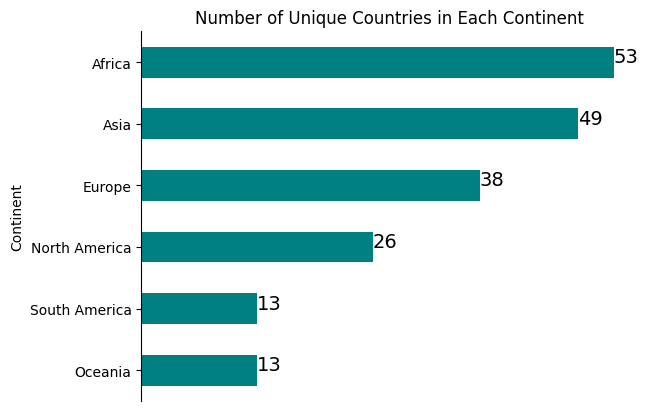

In [ ]:
# @title Number of Unique Countries in Each Continent

# Group by continent and count unique areas (countries), sorted in descending order
continent_area_counts = df.groupby('Continent')['Area'].nunique().sort_values(ascending=True)

# Plotting the horizontal bar chart
# plt.figure(figsize=(10, 6))
bars = continent_area_counts.plot(kind='barh', color='teal')

# Add labels at the end of each bar
for index, value in enumerate(continent_area_counts):
    plt.text(value, index, str(value), va='baseline', ha='left', fontsize=14, color='black')

# Remove the top, right, and bottom border (spines)
bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['bottom'].set_visible(False)

# Remove the x-axis ticks
plt.xticks([])

# Add titles and labels
plt.title('Number of Unique Countries in Each Continent')
plt.ylabel('Continent')

# Display the plot
plt.show()

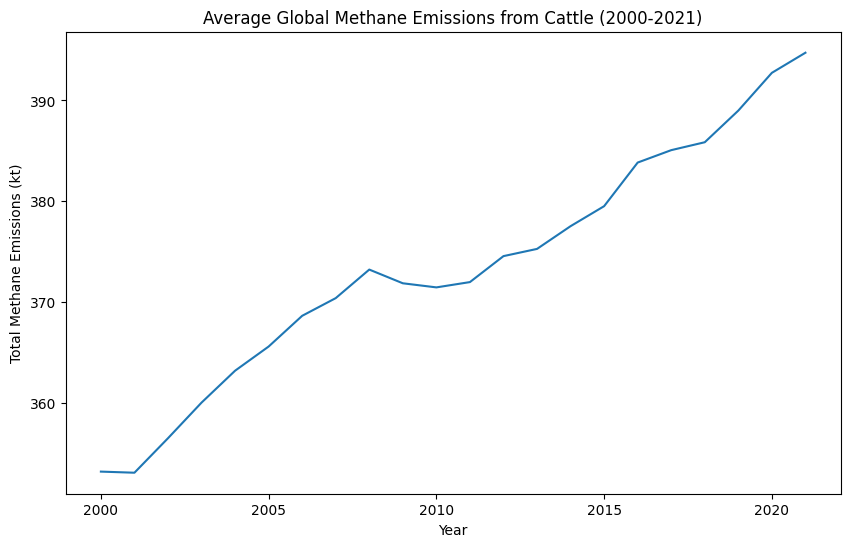

In [ ]:
# @title Average Global Methane Emissions from Cattle (2000-2021)

emissions_by_year = df.groupby('Year')['Value'].mean()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year.index, emissions_by_year.values)
plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
_ = plt.title('Average Global Methane Emissions from Cattle (2000-2021)')

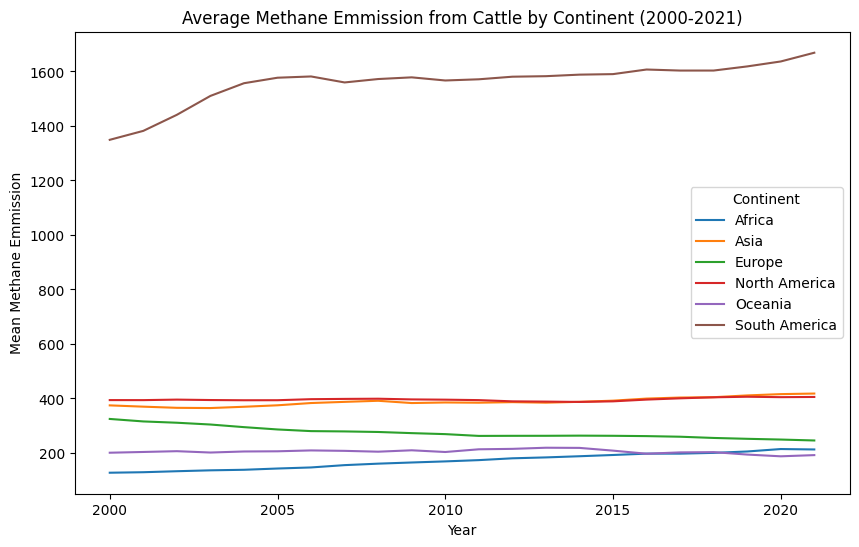

In [ ]:
# @title Average Global Methane Emissions from Cattle (2000-2021)

# Group by Continent and Year, then calculate the mean of the 'Value' (temperature)
mean_temp_by_year_continent = df.groupby(['Year', 'Continent'])['Value'].mean().unstack()

# Plotting the mean Methane Emmission for each continent across the years
mean_temp_by_year_continent.plot(figsize=(10,6))

plt.title('Average Methane Emmission from Cattle by Continent (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Mean Methane Emmission')
plt.legend(title='Continent')
plt.show()

In [ ]:
#@title Average Methane Emissions from Cattle by Continent (2000-2021) - Interactive Chart

# Group the data by continent and year, and calculate the mean of the 'Value' column
emissions_by_continent_year = df.groupby(['Continent', 'Year'])['Value'].mean().reset_index()

# Create an empty figure
fig = go.Figure()

# Add a trace for each continent
continents = emissions_by_continent_year['Continent'].unique()
for continent in continents:
    continent_data = emissions_by_continent_year[emissions_by_continent_year['Continent'] == continent]
    fig.add_trace(go.Scatter(x=continent_data['Year'], y=continent_data['Value'], mode='lines+markers', name=continent, visible=False))

# Make only the first continent visible
fig.data[0].visible = True

# Create dropdown menu options
dropdown_buttons = []
for i, continent in enumerate(continents):
    dropdown_buttons.append(dict(method='update',
                                 label=continent,
                                 args=[{'visible': [j == i for j in range(len(continents))]},
                                       {'title': f'Average Methane Emissions from Cattle in {continent} (2000-2021)'}]))

# Add dropdown to the layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=dropdown_buttons, x=1.15, y=1.15)],
    title=f'Average Methane Emissions from Cattle in {continents[0]} (2000-2021)',
    xaxis_title='Year',
    yaxis_title='Total Methane Emissions (kt)',
)

# Show the figure
fig.show()

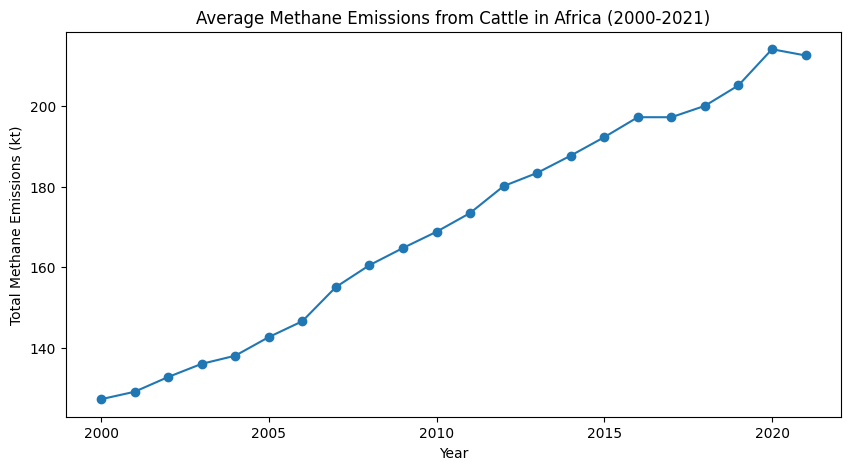

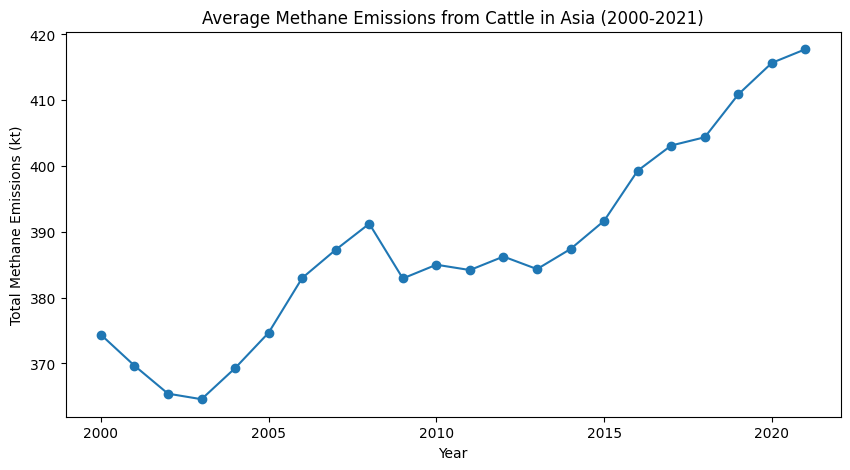

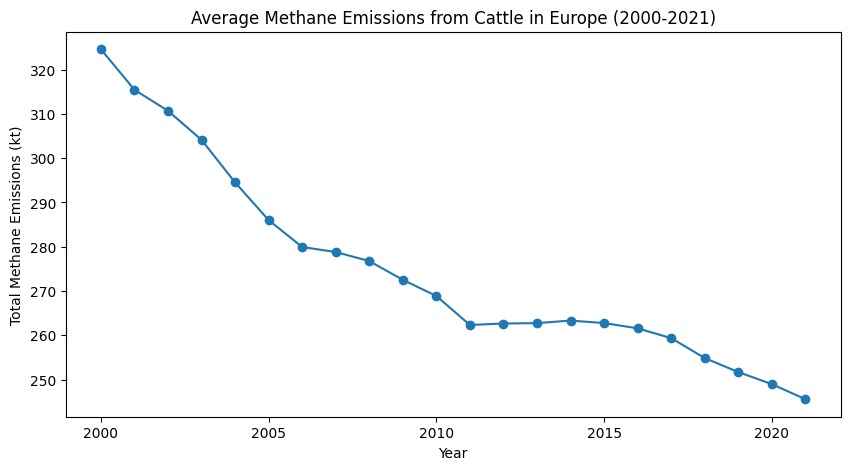

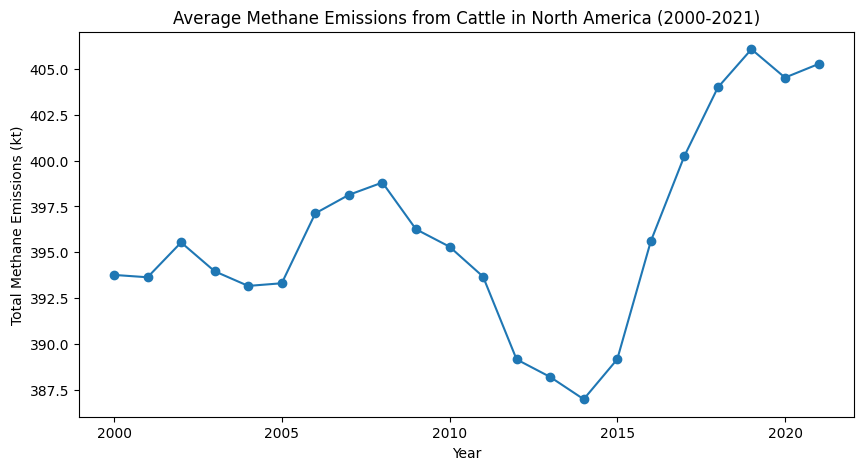

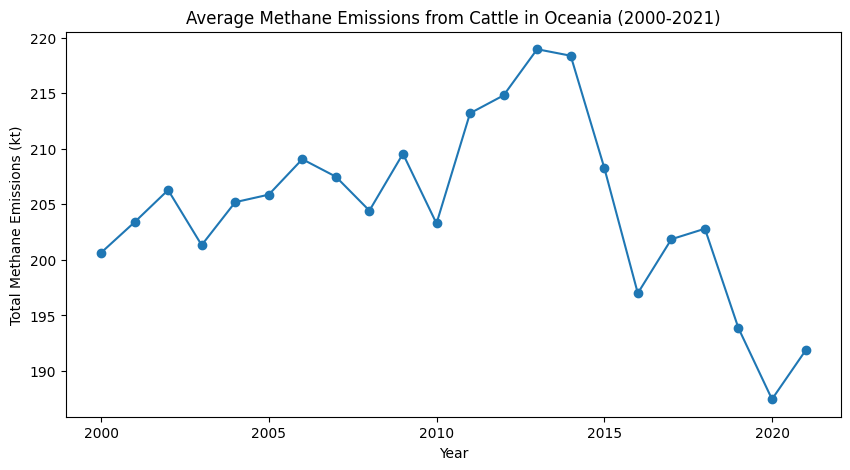

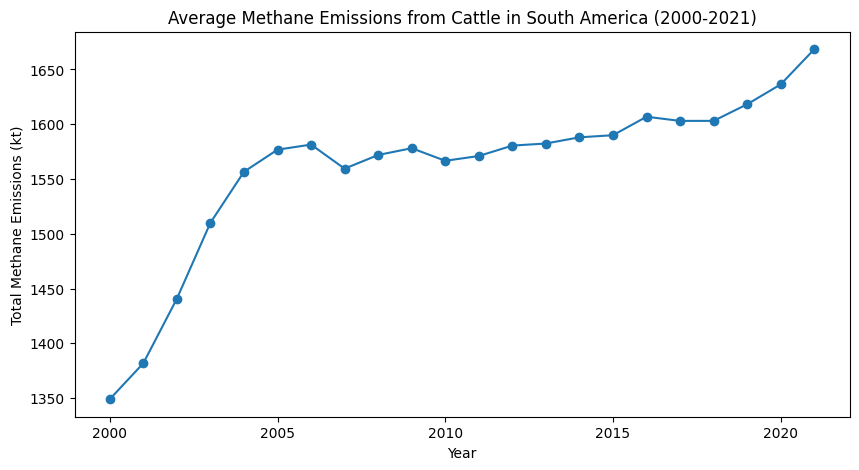

In [ ]:
#@title Average Methane Emissions from Cattle by Continent (2000-2021)
emissions_by_continent_year = df.groupby(['Continent', 'Year'])['Value'].mean().unstack('Continent')

# Create a line chart for each continent
for continent in emissions_by_continent_year.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(emissions_by_continent_year.index, emissions_by_continent_year[continent], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Total Methane Emissions (kt)')
    plt.title(f'Average Methane Emissions from Cattle in {continent} (2000-2021)')
    plt.show()

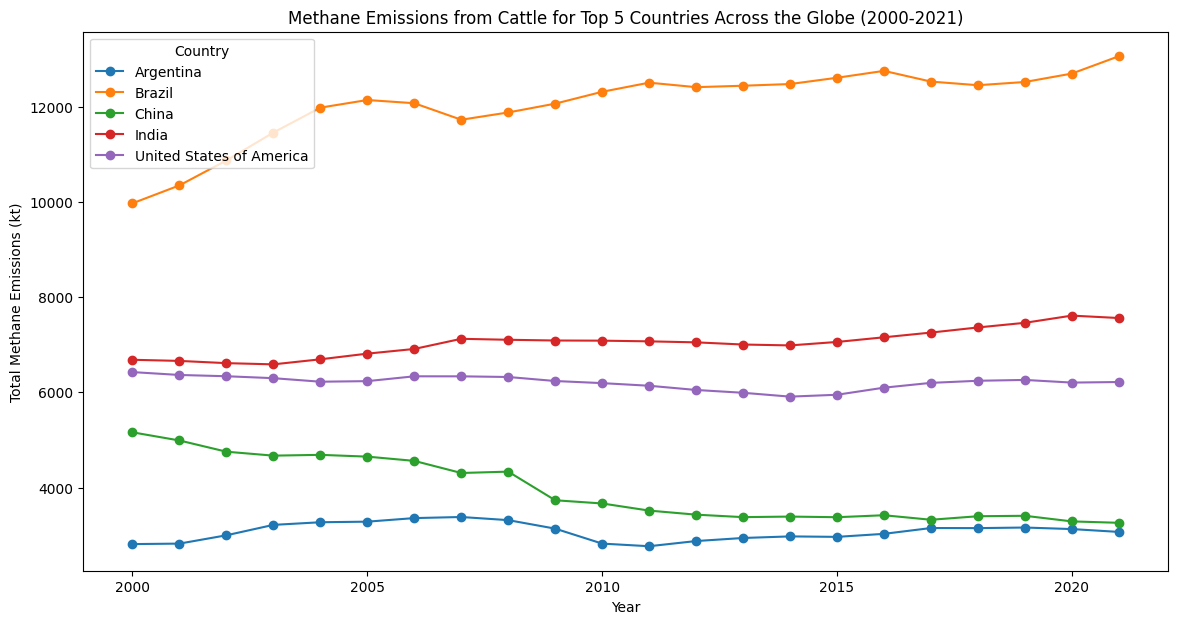

In [ ]:
# @title Methane Emissions from Cattle for Top 5 Countries Across the Globe (2000-2021)

# Calculate total emissions by country
total_emissions_by_country = df.groupby('Area')['Value'].sum()

# Get the top 5 countries with the highest total emissions
top_5_countries = total_emissions_by_country.nlargest(5).index

# Filter the DataFrame for these top 5 countries
df_top_5 = df[df['Area'].isin(top_5_countries)]

# Group by Country and Year
emissions_by_country_year = df_top_5.groupby(['Area', 'Year'])['Value'].sum().unstack('Area')

# Plot line charts for the top 5 countries
plt.figure(figsize=(14, 7))
for country in emissions_by_country_year.columns:
    plt.plot(emissions_by_country_year.index, emissions_by_country_year[country], marker='o', linestyle='-', label=country)

plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
plt.title('Methane Emissions from Cattle for Top 5 Countries Across the Globe (2000-2021)')
plt.legend(title='Country')
plt.show()

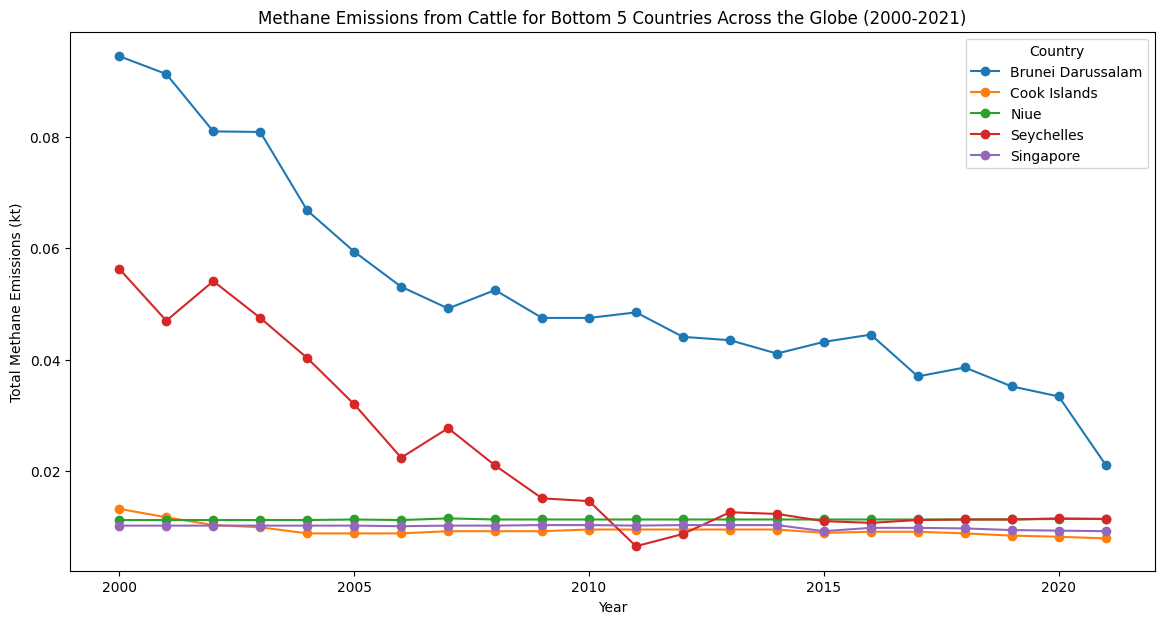

In [ ]:
# @title Methane Emissions from Cattle for Bottom 5 Countries Across the Globe (2000-2021)

# Get the bottom 5 countries with the lowest total emissions
bottom_5_countries = total_emissions_by_country.nsmallest(5).index

# Filter the DataFrame for these bottom 5 countries
df_bottom_5 = df[df['Area'].isin(bottom_5_countries)]

# Group by Country and Year
emissions_by_country_year = df_bottom_5.groupby(['Area', 'Year'])['Value'].sum().unstack('Area')

# Plot line charts for the bottom 5 countries
plt.figure(figsize=(14, 7))
for country in emissions_by_country_year.columns:
    plt.plot(emissions_by_country_year.index, emissions_by_country_year[country], marker='o', linestyle='-', label=country)

plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
plt.title('Methane Emissions from Cattle for Bottom 5 Countries Across the Globe (2000-2021)')
plt.legend(title='Country')
plt.show()

In [ ]:
# Calculate total emissions by country
total_emissions_by_country = df.groupby('Area')['Value'].sum()

# Get the bottom 5 countries with the highest total emissions
bottom_5_countries = total_emissions_by_country.nsmallest(5).index

# Filter the DataFrame for these bottom 5 countries
df_bottom_5 = df[df['Area'].isin(bottom_5_countries)]

# Create the plot using Plotly Express
fig = px.line(df_bottom_5, x='Year', y='Value', color='Area',
              title='Methane Emissions from Cattle for Bottom 5 Countries Across the Globe (2000-2021)',
              labels={'Value': 'Total Methane Emissions (kt)', 'Year': 'Year'},
              markers=True)

# Update layout for better readability
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Total Methane Emissions (kt)',
                  legend_title_text='Country',
                  template='plotly_white')

# Show the plot
fig.show()

## Exploring Top 10 Countries per continent

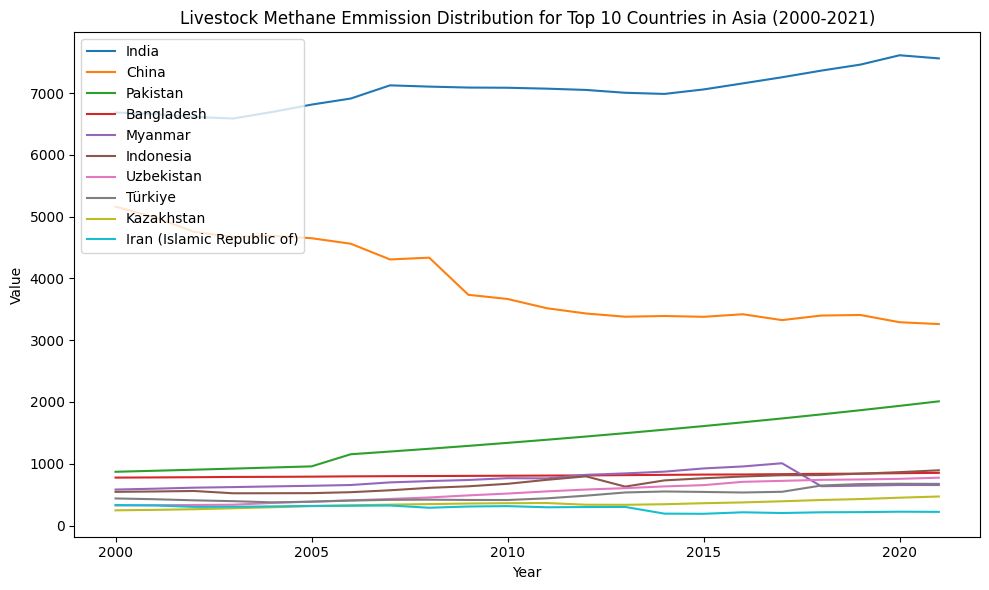

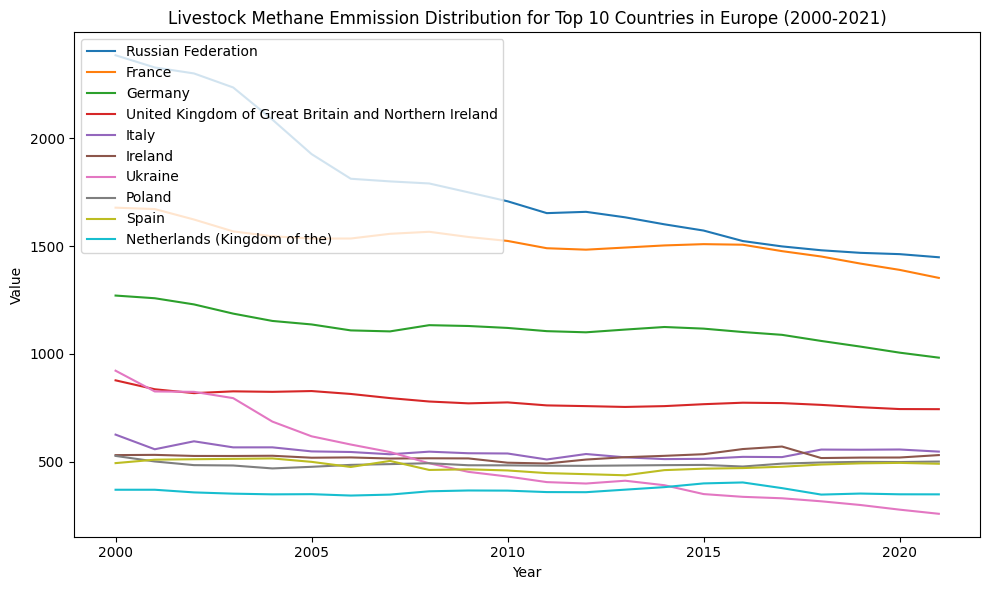

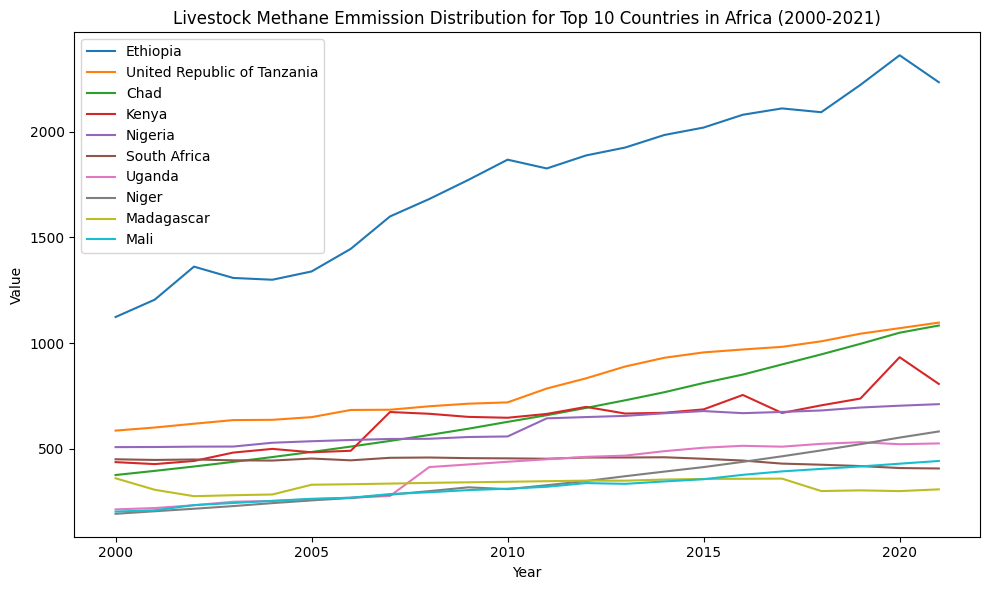

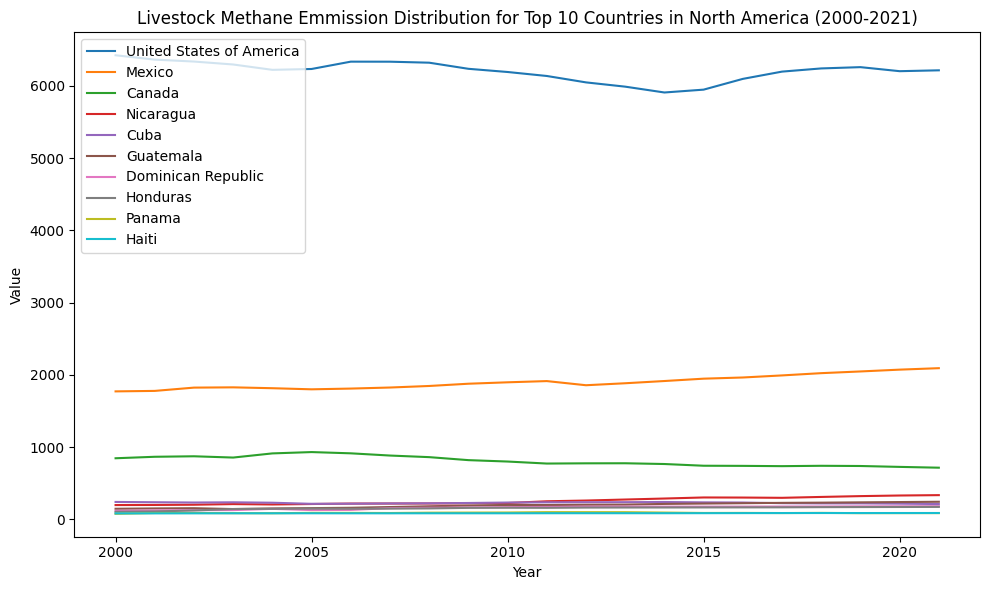

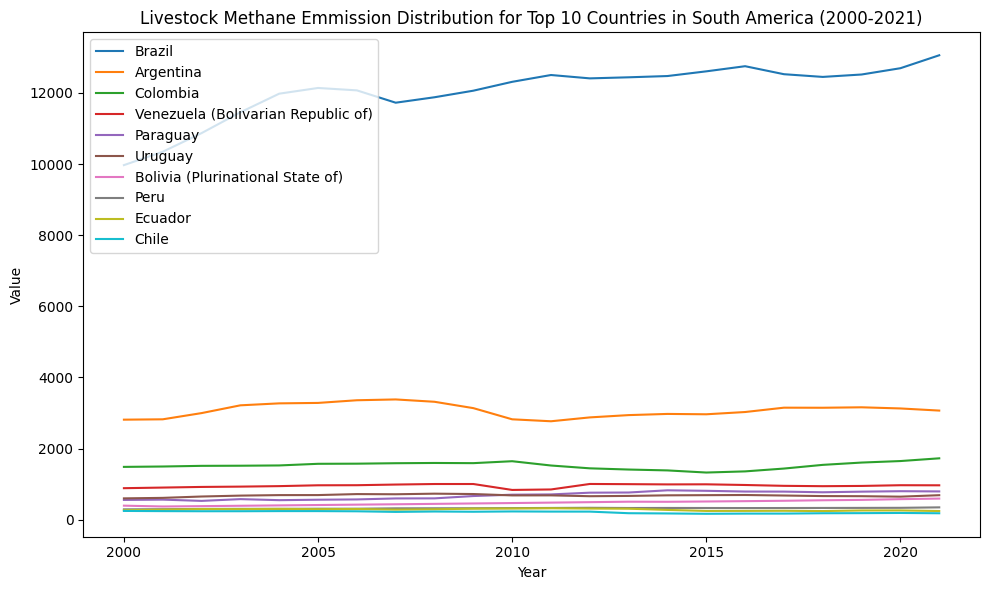

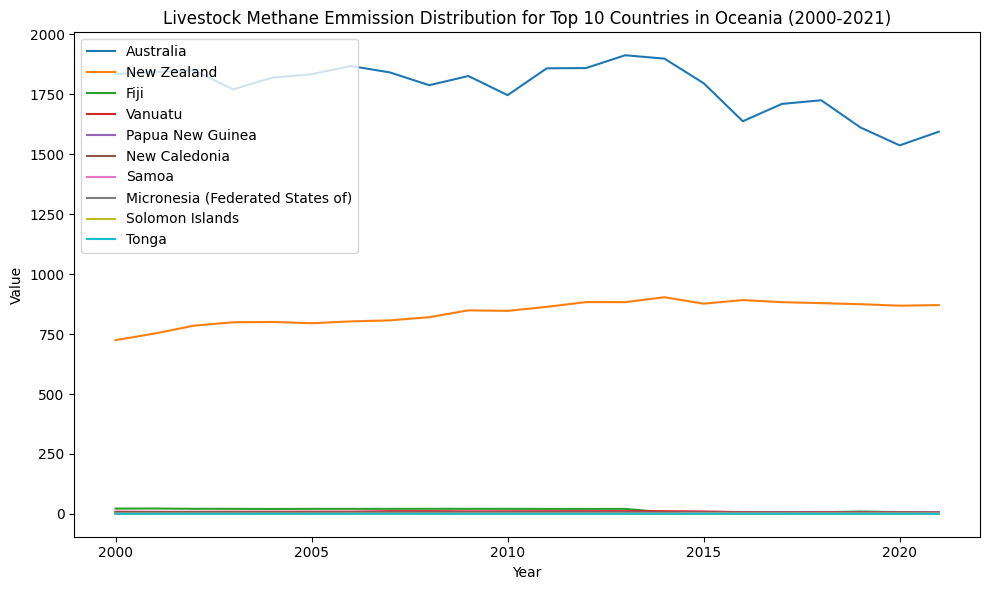

In [ ]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].sum().reset_index()

# Find the top 10 countries per continent based on total Value
top_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].sum().reset_index()
top_10_countries = top_countries_per_continent.groupby('Continent').apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)

# Get unique continents
continents = df['Continent'].unique()

# Plot the trend for top 10 countries per continent
for continent in continents:
    plt.figure(figsize=(10, 6))

    # Get top 10 countries for each continent
    top_countries = top_10_countries[top_10_countries['Continent'] == continent]['Area'].values

    # Filter the dataset to only include top countries
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(top_countries))]

    # Plot lines for each country
    for country in top_countries:
        country_data = continent_data[continent_data['Area'] == country]
        plt.plot(country_data['Year'], country_data['Value'], label=country)

    plt.title(f'Livestock Methane Emmission Distribution for Top 10 Countries in {continent} (2000-2021)')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(loc='upper left')

    # Show the plot for the current continent
    plt.tight_layout()
    plt.show()


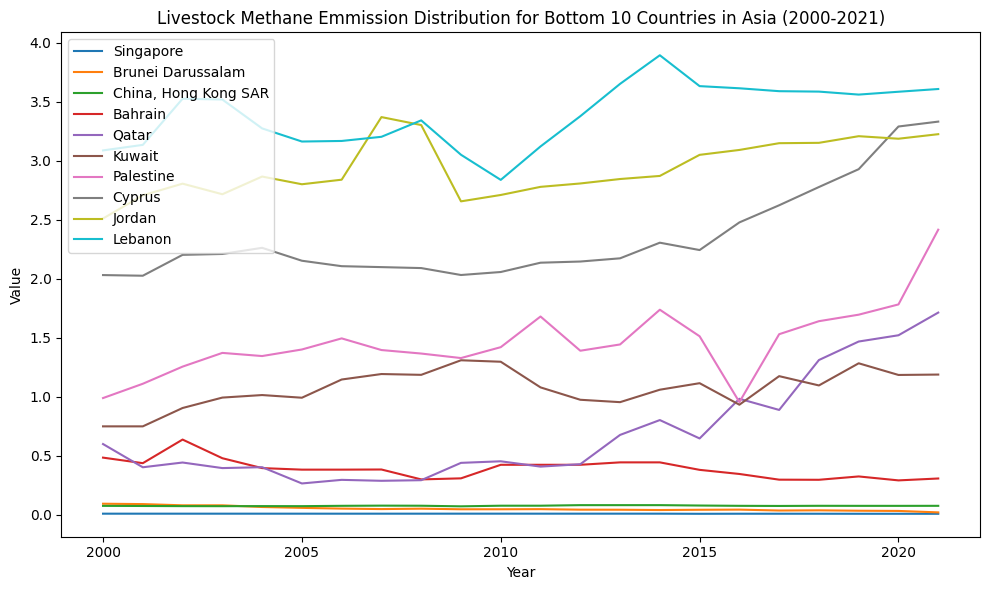

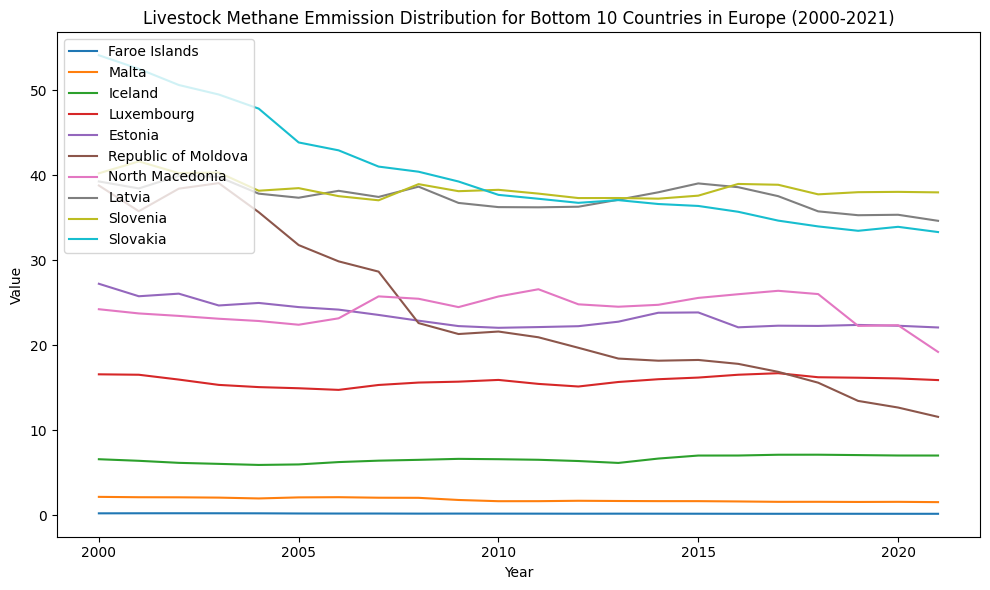

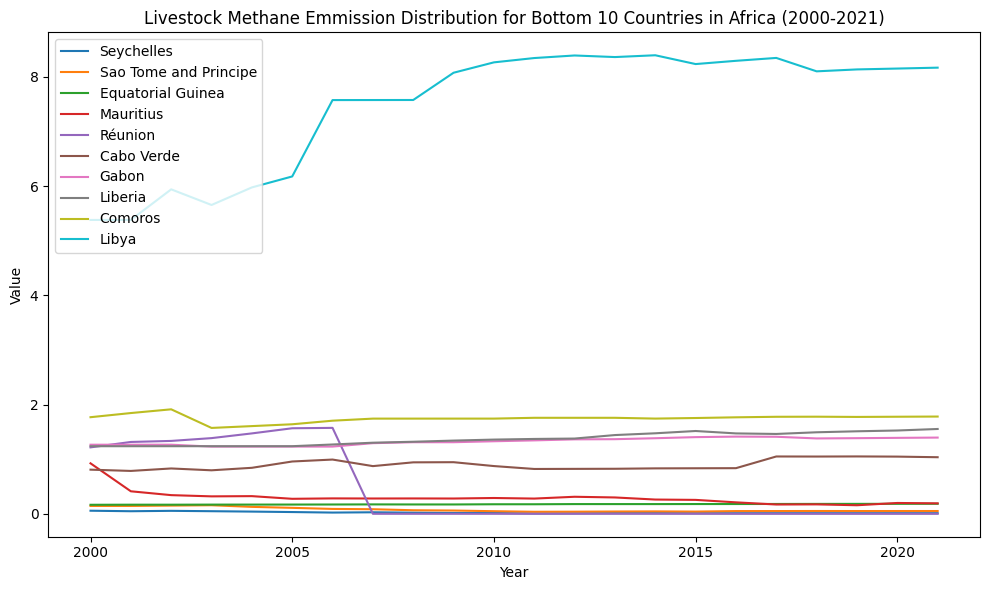

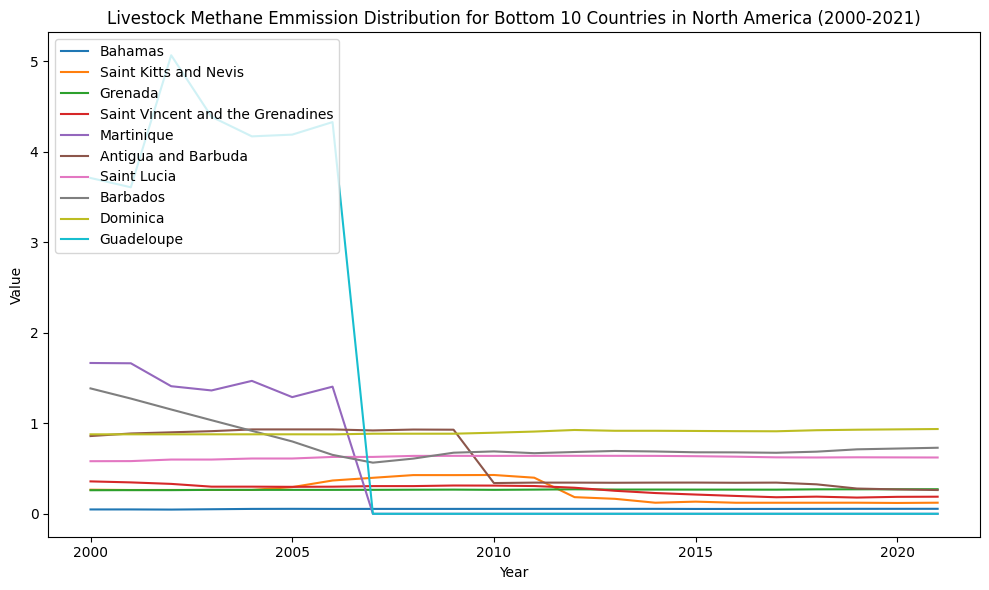

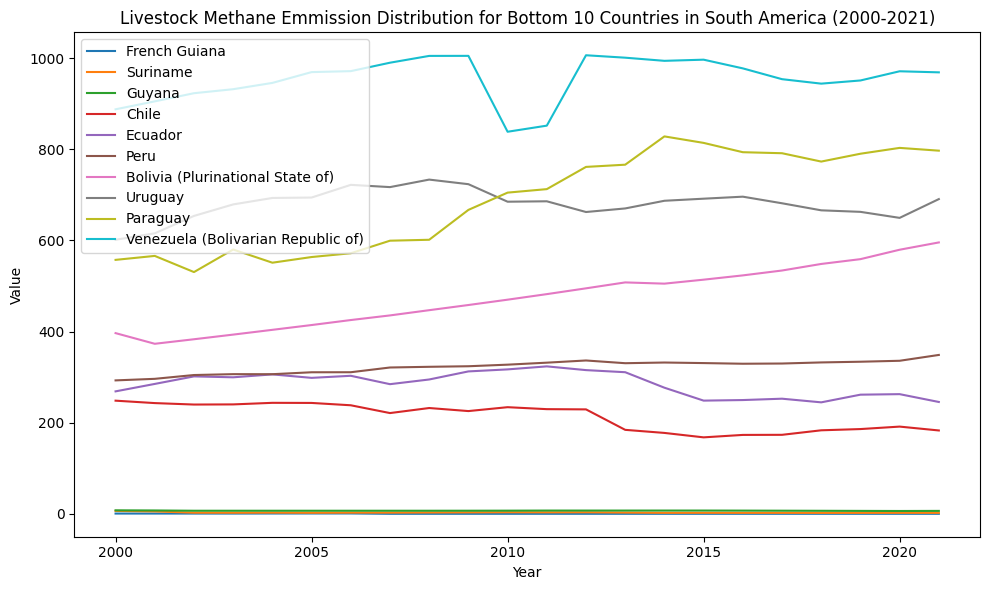

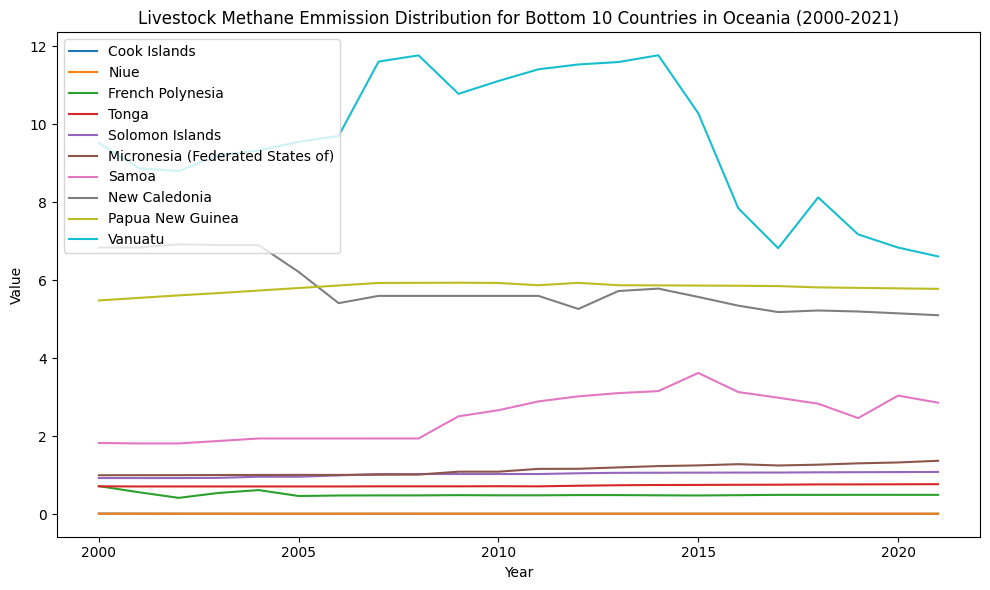

In [ ]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].sum().reset_index()

# Find the bottom 10 countries per continent based on total Value
bottom_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].sum().reset_index()
bottom_10_countries = bottom_countries_per_continent.groupby('Continent').apply(lambda x: x.nsmallest(10, 'Value')).reset_index(drop=True)

# Get unique continents
continents = df['Continent'].unique()

# Plot the trend for bottom 10 countries per continent
for continent in continents:
    plt.figure(figsize=(10, 6))

    # Get bottom 10 countries for each continent
    bottom_countries = bottom_10_countries[bottom_10_countries['Continent'] == continent]['Area'].values

    # Filter the dataset to only include bottom countries
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(bottom_countries))]

    # Plot lines for each country
    for country in bottom_countries:
        country_data = continent_data[continent_data['Area'] == country]
        plt.plot(country_data['Year'], country_data['Value'], label=country)

    plt.title(f'Livestock Methane Emmission Distribution for Bottom 10 Countries in {continent} (2000-2021)')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(loc='upper left')

    # Show the plot for the current continent
    plt.tight_layout()
    plt.show()


In [ ]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].mean().reset_index()

# Find the top 10 countries per continent based on total Value
top_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].mean().reset_index()
top_10_countries = top_countries_per_continent.groupby('Continent').apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)

# Create a figure with dropdown
fig = go.Figure()

# Create dropdown options for each continent
for continent in top_10_countries['Continent'].unique():
    top_countries = top_10_countries[top_10_countries['Continent'] == continent]['Area'].values
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(top_countries))]

    # Add trace for each country in the selected continent
    for country in top_countries:
        country_data = continent_data[continent_data['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'], mode='lines+markers',
                                 name=f'{country} - {continent}',
                                 visible=False))  # Initially set all traces to invisible

# Add visibility toggle through dropdown buttons
buttons = []
for i, continent in enumerate(top_10_countries['Continent'].unique()):
    visible = [False] * len(fig.data)
    start_idx = i * 10  # Each continent has 10 countries
    visible[start_idx:start_idx + 10] = [True] * 10  # Show only the countries for the selected continent

    buttons.append(dict(label=continent,
                        method="update",
                        args=[{"visible": visible},
                              {"title": f"Top 10 Countries' Methane Emission in {continent} (2000-2021)"}]))

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      x=0.17, y=1.15,  # Position the dropdown
                      xanchor='left', yanchor='top')],
    title="Select a Continent to View Top 10 Countries' Methane Emissions",
    xaxis_title="Year",
    yaxis_title="Methane Emission Value (kt)",
    template="plotly_white"
)

# Make the first continent (default) visible
for i in range(10):
    fig.data[i].visible = True

# Show the interactive plot
fig.show()

In [ ]:
#  @title To obtain top 1 and low 1 country per continent

# Group by Continent, Area, and Year, and calculate the total emission ('Value')
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].mean().reset_index()

country_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].mean().reset_index()

# Get the top country for each continent (adjusting to select one top country)
top_1_countries = country_per_continent.groupby('Continent').apply(lambda x: x.nlargest(1, 'Value')).reset_index(drop=True)

# Get the low country for each continent (adjusting to select one low country)
low_1_countries = country_per_continent.groupby('Continent').apply(lambda x: x.nsmallest(1, 'Value')).reset_index(drop=True)

# Display the top 10 countries with their continent
print(top_1_countries[['Continent', 'Area', 'Value']])

print('\n')

# Print the low 10 countries with their continent
print(low_1_countries[['Continent', 'Area', 'Value']])

       Continent                      Area         Value
0         Africa                  Ethiopia   1761.821245
1           Asia                     India   7042.418559
2         Europe        Russian Federation   1777.527877
3  North America  United States of America   6207.610786
4        Oceania                 Australia   1779.620836
5  South America                    Brazil  12055.168623


       Continent           Area     Value
0         Africa     Seychelles  0.022568
1           Asia      Singapore  0.009991
2         Europe  Faroe Islands  0.177200
3  North America        Bahamas  0.053232
4        Oceania   Cook Islands  0.009409
5  South America  French Guiana  0.194282


In [ ]:
# @title Top Emission Country per Continent

# Plot the data using Plotly Express
fig = px.bar(top_1_countries, x='Area', y='Value', color='Continent',
             title='Top Emission Country per Continent',
             labels={'Value': 'Emission Value (kt)', 'Area': 'Country'},
             hover_data=['Continent'])

# Show the plot
fig.show()

In [ ]:
# @title Low Emission Countries per Continent

# Plot the data using Plotly Express
fig = px.bar(low_1_countries, x='Area', y='Value', color='Continent',
             title='Smallest Emission Countries per Continent',
             labels={'Value': 'Emission Value (kt)', 'Area': 'Country'},
             hover_data=['Continent'])

# Show the plot
fig.show()

In [ ]:
# List only the countries per continent
top_countries_list = top_1_countries['Area'].tolist()
low_countries_list = low_1_countries['Area'].tolist()

# Display the list of top countries
print("Top country for each continent: ", top_countries_list)
print("Bottom country for each continent: ", low_countries_list)

Top country for each continent:  ['Ethiopia', 'India', 'Russian Federation', 'United States of America', 'Australia', 'Brazil']
Bottom country for each continent:  ['Seychelles', 'Singapore', 'Faroe Islands', 'Bahamas', 'Cook Islands', 'French Guiana']


## **The African Continent**

In [ ]:
africa_data = df[df['Continent'] == 'Africa']
africa_data['Area'].unique()

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
       'Chad', 'Comoros', 'Congo', "Côte d'Ivoire",
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger',
       'Nigeria', 'Réunion', 'Rwanda', 'Sao Tome and Principe', 'Senegal',
       'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Togo',
       'Tunisia', 'Uganda', 'United Republic of Tanzania', 'Zambia',
       'Zimbabwe'], dtype=object)

There are 53 countries recorded for Africa.

[**Click to explore Regions in Africa**](https://www.worldatlas.com/geography/regions-of-africa.html)

In [ ]:
# map countries into regions using the World Atlas (link above)
east = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique', 'Réunion',
        'Rwanda', 'Seychelles', 'Somalia', 'Uganda', 'United Republic of Tanzania', 'Zambia']
south = ['Botswana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa', 'Zimbabwe']
north = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia']
west = ['Benin', 'Burkina Faso', 'Cabo Verde', "Côte d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania',
        'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo']
central = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']

In [ ]:
# create a dictionary of regions and countries
regions = {'East Africa': east, 'Southern Africa': south, 'North Africa': north, 'West Africa': west, 'Central Africa': central}

# create a function to map countries to regions
def get_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return None

# create a new column 'Region'
africa_data['Region'] = africa_data['Area'].apply(get_region)

# print the updated dataframe
africa_data.head()

<ipython-input-32-129b3bc08f11>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Area,Year,Value,Continent,Region
44,Algeria,2000,64.5483,Africa,North Africa
45,Algeria,2001,66.7373,Africa,North Africa
46,Algeria,2002,61.4546,Africa,North Africa
47,Algeria,2003,63.3324,Africa,North Africa
48,Algeria,2004,66.6834,Africa,North Africa


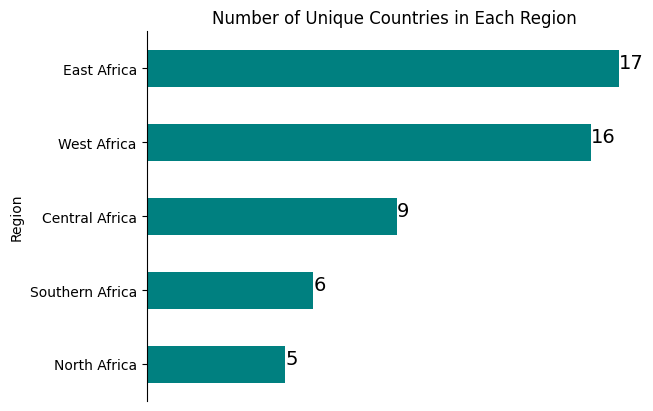

In [ ]:
# @title Number of Unique Countries in Each Region

# Group by Region and count unique areas (countries), sorted in descending order
Region_area_counts = africa_data.groupby('Region')['Area'].nunique().sort_values(ascending=True)

# Plotting the horizontal bar chart
# plt.figure(figsize=(10, 6))
bars = Region_area_counts.plot(kind='barh', color='teal')

# Add labels at the end of each bar
for index, value in enumerate(Region_area_counts):
    plt.text(value, index, str(value), va='baseline', ha='left', fontsize=14, color='black')

# Remove the top, right, and bottom border (spines)
bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['bottom'].set_visible(False)

# Remove the x-axis ticks
plt.xticks([])

# Add titles and labels
plt.title('Number of Unique Countries in Each Region')
plt.ylabel('Region')

# Display the plot
plt.show()

In [ ]:
#Inspect summed statistics of grouped countries as region
africa_data.groupby('Region')['Value'].sum()

,Value
Region,
Central Africa,26151.9158
East Africa,98082.3858
North Africa,8534.9693
Southern Africa,18225.6171
West Africa,47501.9195


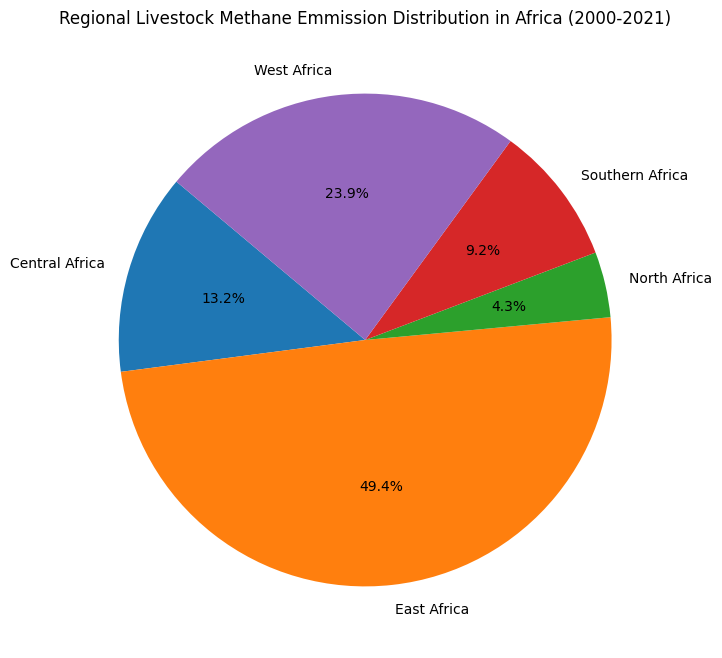

In [ ]:
# @title Regional Livestock Methane Emmission Distribution in Africa (2000-2021)

# Group by 'Region' and sum the 'Value'
region_values = africa_data.groupby('Region')['Value'].sum()
plt.figure(figsize=(8, 8))
plt.pie(region_values, labels=region_values.index, autopct='%1.1f%%', startangle=140)
plt.title('Regional Livestock Methane Emmission Distribution in Africa (2000-2021)')
# plt.axis('equal')
plt.show()

In [ ]:
# @title Livestock Methane Emmission Distribution for African Regions (2000-2021)

# Group by 'Region' and sum the 'Value'
region_value_sum = africa_data.groupby('Region')['Value'].sum().reset_index()

# Sort the data by 'Value' in ascending order
region_value_sum = region_value_sum.sort_values(by='Value', ascending=True)

# Create a horizontal bar chart
fig = px.bar(region_value_sum,
             x='Value',
             y='Region',
             orientation='h',  # Horizontal bars
             title='Total Methane Emissions by Region in Africa',
             labels={'Value': 'Total Methane Emissions (kt)', 'Region': 'Region'},
             text='Value')  # Add text labels

# Customize layout
fig.update_layout(
    template='plotly_white',
    xaxis=dict(showticklabels=False),  # Remove x-axis ticks
    showlegend=False
)

# Add labels to the end of each bar
fig.update_traces(textposition='outside')

# Remove the top, right, and bottom border
fig.update_layout(
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis=dict(showline=False),
    xaxis=dict(showline=False)
)

# Show the plot
fig.show()

In [ ]:
#@title Average Methane Emissions from Cattle by African Region (2000-2021)

# Group the data by Region and year, and calculate the mean of the 'Value' column
emissions_by_Region_year = africa_data.groupby(['Region', 'Year'])['Value'].mean().reset_index()

# Create an empty figure
fig = go.Figure()

# Add a trace for each Region
Regions = emissions_by_Region_year['Region'].unique()
for Region in Regions:
    Region_data = emissions_by_Region_year[emissions_by_Region_year['Region'] == Region]
    fig.add_trace(go.Scatter(x=Region_data['Year'], y=Region_data['Value'], mode='lines+markers', name=Region, visible=False))

# Make only the first Region visible
fig.data[0].visible = True

# Create dropdown menu options
dropdown_buttons = []
for i, Region in enumerate(Regions):
    dropdown_buttons.append(dict(method='update',
                                 label=Region,
                                 args=[{'visible': [j == i for j in range(len(Regions))]},
                                       {'title': f'Average Methane Emissions from Cattle in {Region} (2000-2021)'}]))

# Add dropdown to the layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=dropdown_buttons, x=1.15, y=1.15)],
    title=f'Average Methane Emissions from Cattle in {Regions[0]} (2000-2021)',
    xaxis_title='Year',
    yaxis_title='Total Methane Emissions (kt)',
)

# Show the figure
fig.show()

In [ ]:
# @title Top 5 Countries' Methane Emission in Africa Regions

# Group by Region, Area, and Year, and average the 'Value'
grouped = africa_data.groupby(['Region', 'Area', 'Year'])['Value'].mean().reset_index()

# Find the top 5 countries per Region based on total Value
top_countries_per_Region = grouped.groupby(['Region', 'Area'])['Value'].mean().reset_index()
top_5_countries = top_countries_per_Region.groupby('Region').apply(lambda x: x.nlargest(5, 'Value')).reset_index(drop=True)

# Create a figure with dropdown
fig = go.Figure()

# Create dropdown options for each Region
for Region in top_5_countries['Region'].unique():
    top_countries = top_5_countries[top_5_countries['Region'] == Region]['Area'].values
    Region_data = grouped[(grouped['Region'] == Region) & (grouped['Area'].isin(top_countries))]

    # Add trace for each country in the selected Region
    for country in top_countries:
        country_data = Region_data[Region_data['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'], mode='lines+markers',
                                 name=f'{country} - {Region}',
                                 visible=False))  # Initially set all traces to invisible

# Add visibility toggle through dropdown buttons
buttons = []
for i, Region in enumerate(top_5_countries['Region'].unique()):
    visible = [False] * len(fig.data)
    start_idx = i * 5  # Each Region has 5 countries
    visible[start_idx:start_idx + 5] = [True] * 5  # Show only the countries for the selected Region

    buttons.append(dict(label=Region,
                        method="update",
                        args=[{"visible": visible},
                              {"title": f"Top 5 Countries' Methane Emission in {Region} (2000-2021)"}]))

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      x=0.17, y=1.15,  # Position the dropdown
                      xanchor='left', yanchor='top')],
    title="Select an African Region to View Top 5 Countries' Methane Emissions",
    xaxis_title="Year",
    yaxis_title="Methane Emission Value (kt)",
    template="plotly_white"
)

# Make the first Region (default) visible
for i in range(5):
    fig.data[i].visible = True

# Show the interactive plot
fig.show()

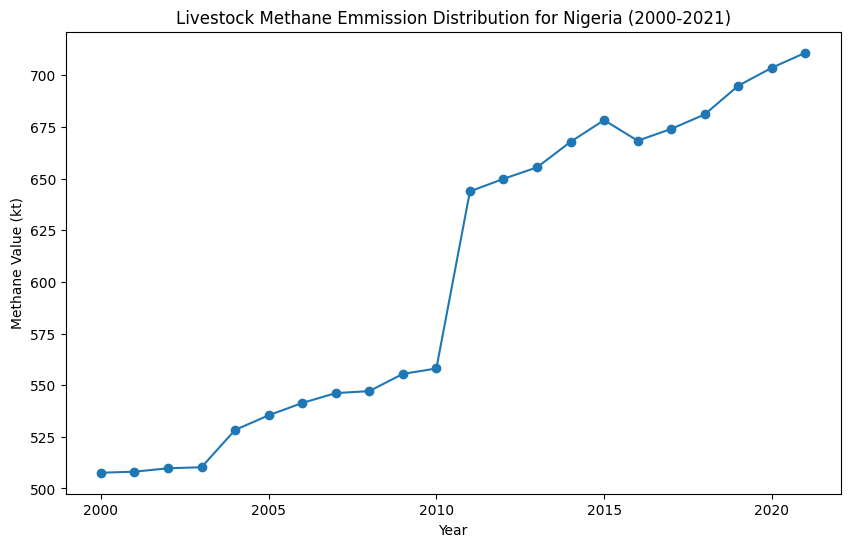

In [ ]:
# @title Livestock Methane Emmission Distribution for Nigeria (2000-2021)

plt.figure(figsize=(10, 6))
Nigeria_data = df[df['Area'] == 'Nigeria']
plt.plot(Nigeria_data['Year'], Nigeria_data['Value'], marker='o')
plt.title('Livestock Methane Emmission Distribution for Nigeria (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Methane Value (kt)');

In [ ]:
# Filter the data for Nigeria
Nigeria_data = df[df['Area'] == 'Nigeria']

# Plot the line chart using Plotly Express
fig = px.line(Nigeria_data, x='Year', y='Value', markers=True,
              title='Livestock Methane Emission Distribution for Nigeria (2000-2021)',
              labels={'Value': 'Methane Value (kt)', 'Year': 'Year'})

# Customize layout (optional)
fig.update_layout(
    title_x=0.5,  # Center title
    xaxis_title='Year',
    yaxis_title='Methane Value (kt)',
    showlegend=False
)

# Display the plot
fig.show()

## Modeling

In [ ]:
# import libraries
from prophet import Prophet

In [ ]:
df.head()

,Area,Year,Value,Continent
0,Afghanistan,2000,152.100,Asia
1,Afghanistan,2001,119.621,Asia
2,Afghanistan,2002,196.135,Asia
3,Afghanistan,2003,199.441,Asia
4,Afghanistan,2004,182.926,Asia


In [ ]:
prophet_data = df.copy()
prophet_data['Year'] = pd.to_datetime(prophet_data['Year'], format='%Y')
prophet_data.head()

,Area,Year,Value,Continent
0,Afghanistan,2000-01-01,152.100,Asia
1,Afghanistan,2001-01-01,119.621,Asia
2,Afghanistan,2002-01-01,196.135,Asia
3,Afghanistan,2003-01-01,199.441,Asia
4,Afghanistan,2004-01-01,182.926,Asia


In [ ]:
# Select the country and prepare the data for Prophet
selected_country = 'Nigeria'
country_data = prophet_data[prophet_data['Area'] == selected_country]

# Prepare the DataFrame for model
model_data = country_data[['Year', 'Value']].rename(columns={'Year': 'ds', 'Value': 'y'})
model_data.head()

,ds,y
2810,2000-01-01,507.5981
2811,2001-01-01,508.1038
2812,2002-01-01,509.7452
2813,2003-01-01,510.2584
2814,2004-01-01,528.3050


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/c5007q1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/n5pjvycm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7144', 'data', 'file=/tmp/tmpvj2ym02l/c5007q1p.json', 'init=/tmp/tmpvj2ym02l/n5pjvycm.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelw17himgq/prophet_model-20240926073020.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

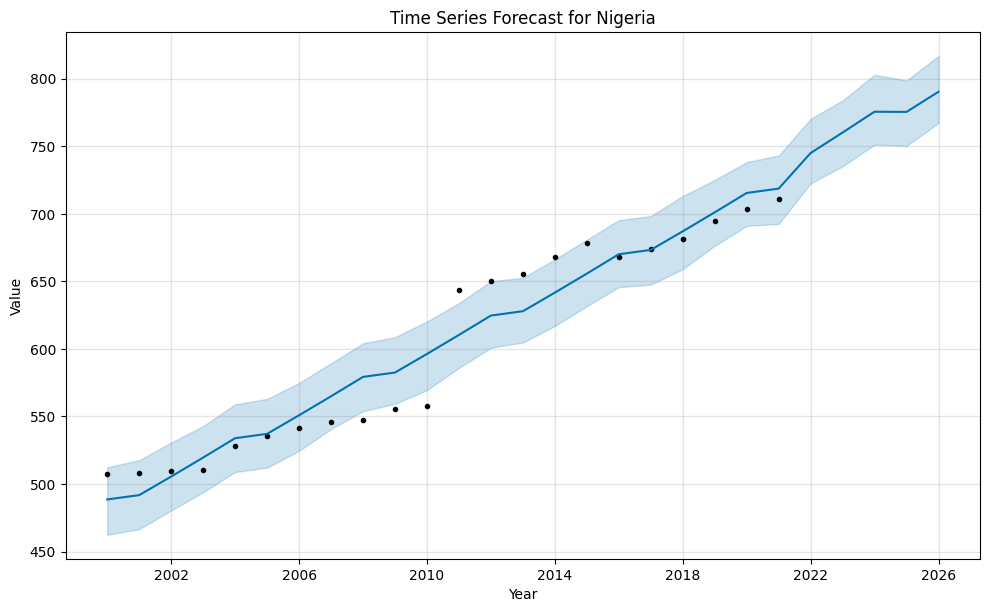

In [ ]:
# Fit the Prophet model
model = Prophet()
model.fit(model_data)

# Create future dates for prediction of 5 years ahead with a yearly frequency
future = model.make_future_dataframe(periods=5, freq= 'Y')


# predict the future values
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Time Series Forecast for {selected_country}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

<Axes: xlabel='ds'>

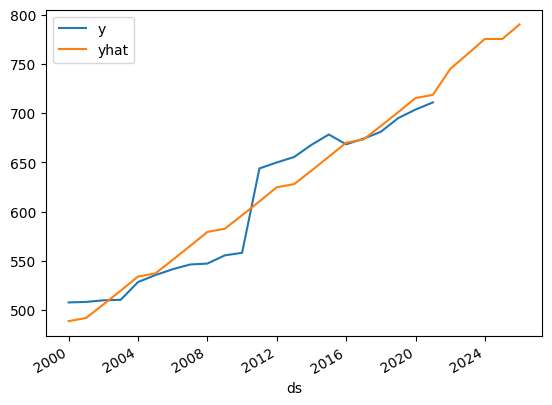

In [ ]:
# plot of original and forecast methane emission value line chart
pd.concat([model_data.set_index('ds')['y'],
           forecast.set_index('ds')['yhat']],axis=1).plot()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/1i51s65f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/w61ms08w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5322', 'data', 'file=/tmp/tmpvj2ym02l/1i51s65f.json', 'init=/tmp/tmpvj2ym02l/w61ms08w.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelbqyu07ok/prophet_model-20240926075154.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Creating Prophet model for Ethiopia


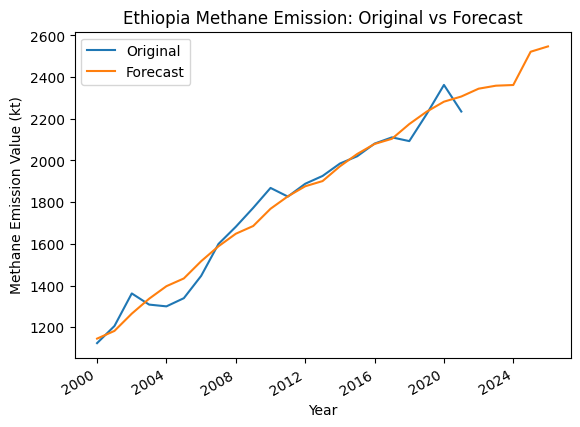

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/z8krtgw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/f3yqfgm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91632', 'data', 'file=/tmp/tmpvj2ym02l/z8krtgw2.json', 'init=/tmp/tmpvj2ym02l/f3yqfgm_.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelybg321ir/prophet_model-20240926075155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for India


07:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


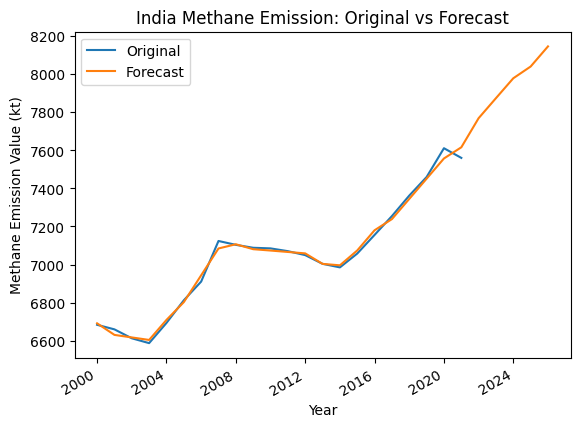

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/ia3k9ser.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/tai00uxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29673', 'data', 'file=/tmp/tmpvj2ym02l/ia3k9ser.json', 'init=/tmp/tmpvj2ym02l/tai00uxn.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelwoywzayo/prophet_model-20240926075155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Russian Federation


07:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


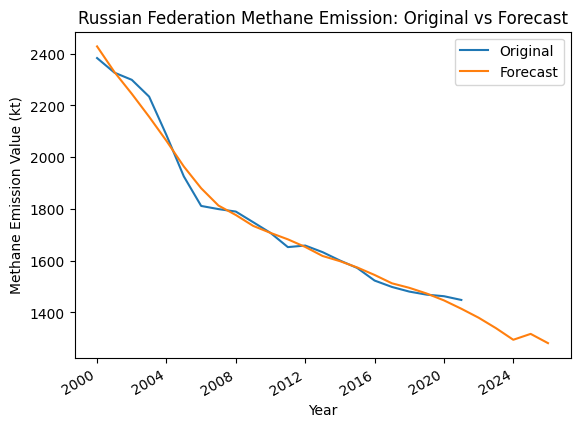

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/cvk3mnrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/jj9uisr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2876', 'data', 'file=/tmp/tmpvj2ym02l/cvk3mnrn.json', 'init=/tmp/tmpvj2ym02l/jj9uisr7.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelvx_j9zj1/prophet_model-20240926075156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Creating Prophet model for United States of America


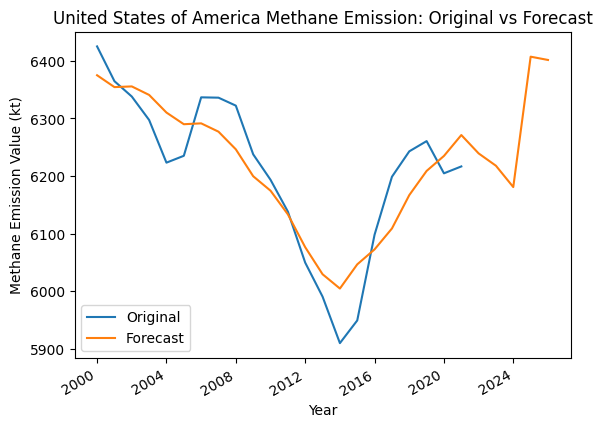

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/c5ozhkwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/p7ivmo5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82839', 'data', 'file=/tmp/tmpvj2ym02l/c5ozhkwi.json', 'init=/tmp/tmpvj2ym02l/p7ivmo5e.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_model8abq1qe4/prophet_model-20240926075157.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Creating Prophet model for Australia


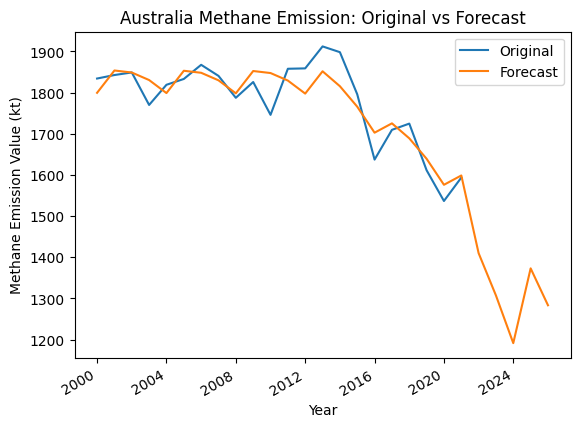

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/9s7g9ylq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/j1_7nwuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53573', 'data', 'file=/tmp/tmpvj2ym02l/9s7g9ylq.json', 'init=/tmp/tmpvj2ym02l/j1_7nwuc.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelergjsusm/prophet_model-20240926075157.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Brazil


07:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


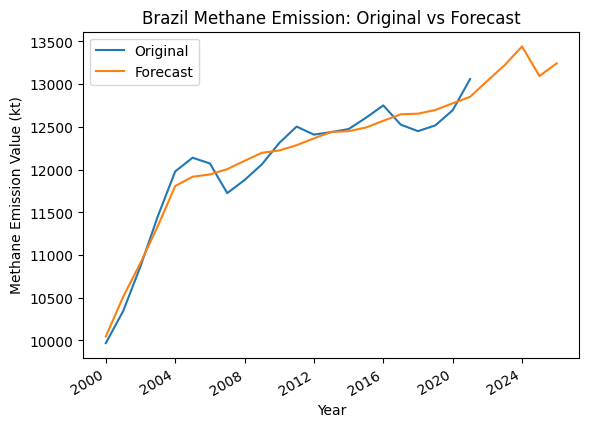

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/ser2b72p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/2u51b0kp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84670', 'data', 'file=/tmp/tmpvj2ym02l/ser2b72p.json', 'init=/tmp/tmpvj2ym02l/2u51b0kp.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelnctve4c5/prophet_model-20240926075158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Creating Prophet model for Seychelles


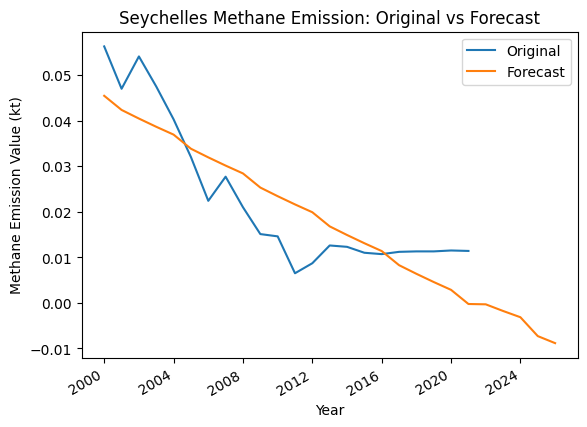

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/3e94qvz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/9u89v2io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86514', 'data', 'file=/tmp/tmpvj2ym02l/3e94qvz5.json', 'init=/tmp/tmpvj2ym02l/9u89v2io.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_model1se5sa6c/prophet_model-20240926075159.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Singapore


07:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


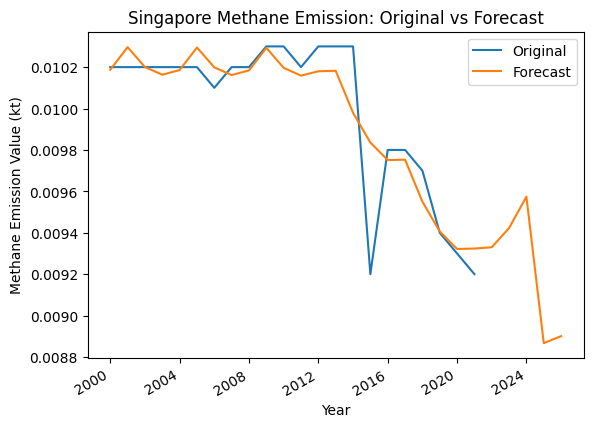

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/wm51q_ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/dgw3kay1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14192', 'data', 'file=/tmp/tmpvj2ym02l/wm51q_ex.json', 'init=/tmp/tmpvj2ym02l/dgw3kay1.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_model6lziw7fc/prophet_model-20240926075159.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Faroe Islands


07:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


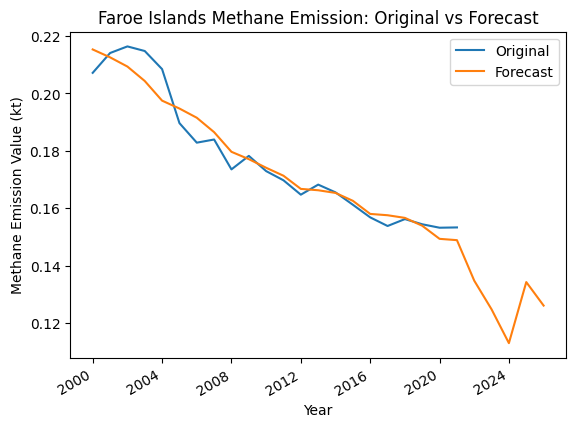

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/gijcal6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/lzmvnrd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60743', 'data', 'file=/tmp/tmpvj2ym02l/gijcal6g.json', 'init=/tmp/tmpvj2ym02l/lzmvnrd5.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_model2jbbgvaq/prophet_model-20240926075200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Bahamas


07:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


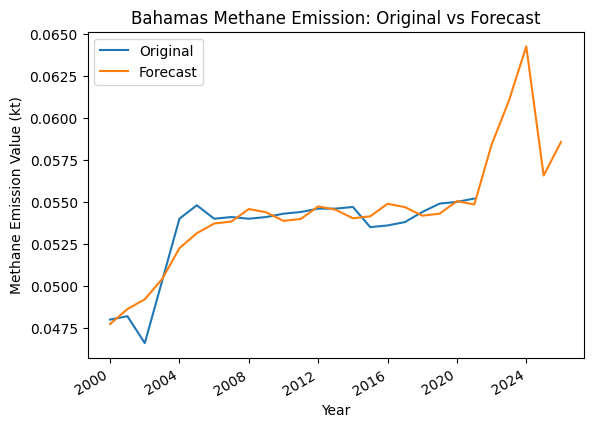

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/8n1uf4d6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/c20get3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64686', 'data', 'file=/tmp/tmpvj2ym02l/8n1uf4d6.json', 'init=/tmp/tmpvj2ym02l/c20get3n.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_model4sttxb33/prophet_model-20240926075201.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for Cook Islands


07:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


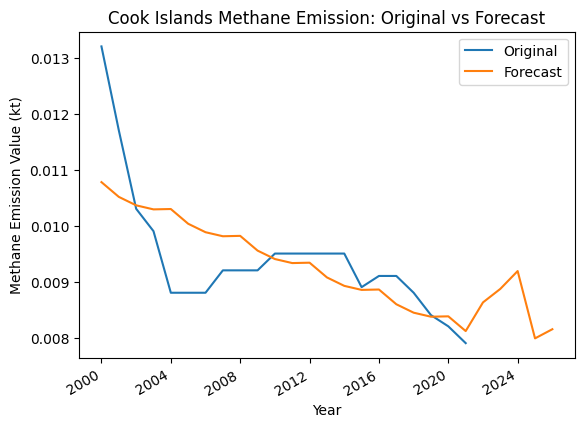

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/4_ijiwsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvj2ym02l/zg3vtoj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9785', 'data', 'file=/tmp/tmpvj2ym02l/4_ijiwsd.json', 'init=/tmp/tmpvj2ym02l/zg3vtoj2.json', 'output', 'file=/tmp/tmpvj2ym02l/prophet_modelywjzcrep/prophet_model-20240926075202.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creating Prophet model for French Guiana


07:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


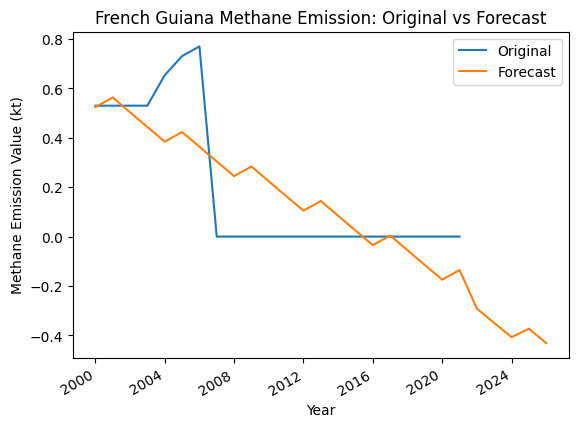

In [ ]:
# Lists of countries
# top_countries_list =
# low_countries_list =


# Function to create Prophet model for each country and plot
def create_prophet_model(country, df):
    # Filter the data for the selected country
    country_data = df[df['Area'] == country]

    # Prepare the DataFrame for Prophet
    model_data = country_data[['Year', 'Value']].rename(columns={'Year': 'ds', 'Value': 'y'})

    # Initialize Prophet model
    model = Prophet()

    # Fit the model on the data
    model.fit(model_data)

    # Create a dataframe for future predictions
    future = model.make_future_dataframe(periods=5, freq='Y') # predict the next 5 years

    # Make predictions
    forecast = model.predict(future)

    # Combine actual and predicted values for plotting
    combined_data = pd.concat([model_data.set_index('ds')['y'],
                               forecast.set_index('ds')['yhat']], axis=1)

    # Plot original and forecast methane emission value line chart
    combined_data.plot(title=f'{country} Methane Emission: Original vs Forecast')
    plt.xlabel('Year')
    plt.ylabel('Methane Emission Value (kt)')
    plt.legend(['Original', 'Forecast'])
    plt.show()

# Loop through top and low countries to create models and forecasts
for country in top_countries_list + low_countries_list:
    print(f"Creating Prophet model for {country}")
    create_prophet_model(country, prophet_data)
